<a href="https://colab.research.google.com/github/padmacharan-123/APPLIED-AI-REC-1/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip -q install -U imbalanced-learn
!pip -q install -U tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 19.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.20.0 which is incompatible.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.20.0 which is incompatible.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# GPU check
gpus = tf.config.list_physical_devices('GPU')
print("GPUs found:", gpus)

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled")
    except Exception as e:
        print("GPU memory growth setup error:", e)
else:
    print("⚠️ No GPU detected. In Colab: Runtime > Change runtime type > GPU")


GPUs found: []
⚠️ No GPU detected. In Colab: Runtime > Change runtime type > GPU


In [8]:
import os

DATA_PATH = "/content/creditcard.csv"   # Colab upload path

if not os.path.exists(DATA_PATH):
    print(f"❌ Error: File not found at {DATA_PATH}")
    print("Please upload 'creditcard.csv' to the Colab session storage or check the path.")
else:
    df = pd.read_csv(DATA_PATH)

    print("Shape before dropping NaNs:", df.shape)

    # Target column
    target_col = "Class"

    # Drop rows where target is NaN to avoid IntCastingNaNError
    df = df.dropna(subset=[target_col])

    # EXCLUDE Time column from features (as you requested)
    X = df.drop(columns=[target_col, "Time"])
    y = df[target_col].astype(int)

    print("Shape after dropping NaNs:", df.shape)
    print("\nUsed features:", X.columns[:8].tolist(), "...")
    print("Class distribution:\n", y.value_counts())

Shape before dropping NaNs: (11715, 31)
Shape after dropping NaNs: (11714, 31)

Used features: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8'] ...
Class distribution:
 Class
0    11664
1       50
Name: count, dtype: int64


In [9]:
def build_mlp(input_dim, lr=0.001):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),

        layers.Dense(256, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.30),

        layers.Dense(128, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.30),

        layers.Dense(64, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.20),

        layers.Dense(1, activation="sigmoid")  # Output layer
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.AUC(name="auc"),
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall")
        ]
    )
    return model


In [13]:
def run_experiment(X, y, split_name, train_size, val_size, test_size,
                   random_state=42, epochs=50, batch_size=2048):

    assert abs(train_size + val_size + test_size - 1.0) < 1e-9, "Splits must sum to 1.0"

    # 1) Split train vs remainder
    X_train, X_rem, y_train, y_rem = train_test_split(
        X, y,
        test_size=(1.0 - train_size),
        stratify=y,
        random_state=random_state
    )

    # 2) If validation is needed, split remainder into val & test
    if val_size == 0.0:
        X_val, y_val = None, None
        X_test, y_test = X_rem, y_rem
    else:
        # remainder = val + test
        test_prop_within_rem = test_size / (val_size + test_size)
        X_val, X_test, y_val, y_test = train_test_split(
            X_rem, y_rem,
            test_size=test_prop_within_rem,
            stratify=y_rem,
            random_state=random_state
        )

    # 3) StandardScaler (fit only on training)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)
    if X_val is not None:
        X_val_s = scaler.transform(X_val)

    # 4) SMOTE (ONLY on training data)
    smote = SMOTE(random_state=random_state)
    X_train_sm, y_train_sm = smote.fit_resample(X_train_s, y_train)

    print("\n" + "="*90)
    print(split_name)
    print(f"Split: Train={train_size}, Val={val_size}, Test={test_size}")
    print("Train distribution before SMOTE:", np.bincount(y_train))
    print("Train distribution after  SMOTE:", np.bincount(y_train_sm))

    # 5) Build + train model
    tf.keras.utils.set_random_seed(random_state)
    model = build_mlp(input_dim=X_train_sm.shape[1], lr=0.001)

    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor="val_auc" if X_val is not None else "auc",
            mode="max",
            patience=5,
            restore_best_weights=True
        )
    ]

    history = model.fit(
        X_train_sm, y_train_sm,
        validation_data=(X_val_s, y_val) if X_val is not None else None,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=callbacks
    )

    # 6) Predict (Test)
    y_prob = model.predict(X_test_s, verbose=0).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    # 7) Metrics
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)
    auc  = roc_auc_score(y_test, y_prob)

    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC-AUC:   {auc:.4f}")

    # 8) Plots
    # (a) Loss curve
    plt.figure()
    plt.plot(history.history["loss"], label="train_loss")
    if X_val is not None:
        plt.plot(history.history["val_loss"], label="val_loss")
    plt.title(f"{split_name} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # (b) AUC curve
    plt.figure()
    plt.plot(history.history["auc"], label="train_auc")
    if X_val is not None:
        plt.plot(history.history["val_auc"], label="val_auc")
    plt.title(f"{split_name} - AUC")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.show()

    # (c) Confusion matrix plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    plt.imshow(cm)
    plt.title(f"{split_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.xticks([0,1], ["0 Legit", "1 Fraud"])
    plt.yticks([0,1], ["0 Legit", "1 Fraud"])
    plt.show()

    # (d) ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.4f})")
    plt.plot([0,1], [0,1], linestyle="--")
    plt.title(f"{split_name} - ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    return {
        "split": split_name,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": auc,
        "confusion_matrix": cm
    }



1) Train-Test 80-20
Split: Train=0.8, Val=0.0, Test=0.2
Train distribution before SMOTE: [9331   40]
Train distribution after  SMOTE: [9331 9331]
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - auc: 0.7938 - loss: 0.5574 - precision: 0.7571 - recall: 0.7057
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - auc: 0.9974 - loss: 0.0849 - precision: 0.9925 - recall: 0.9504
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - auc: 0.9994 - loss: 0.0435 - precision: 0.9837 - recall: 0.9946
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.9998 - loss: 0.0256 - precision: 0.9925 - recall: 0.9982
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - auc: 0.9999 - loss: 0.0192 - precision: 0.9944 - recall: 0.9976
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - auc: 0.9999 - loss: 0.0135 - precision: 0.9960 - recall: 0.9998
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - auc: 0.9999 - loss: 0.0101 - precision: 0.9971 - recall: 0.9996
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━

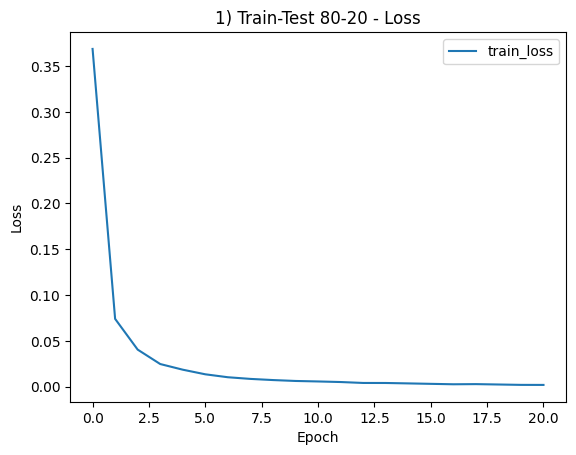

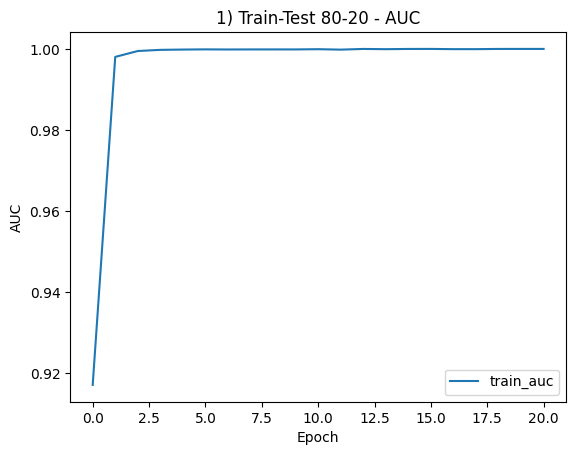

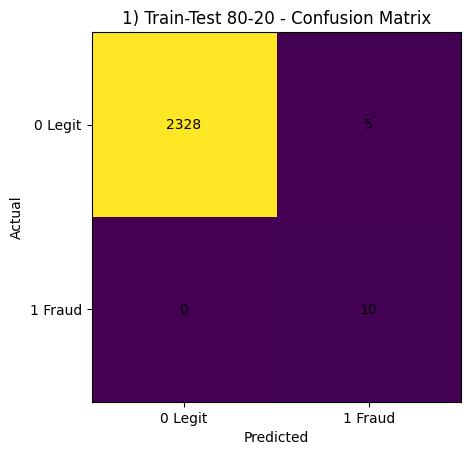

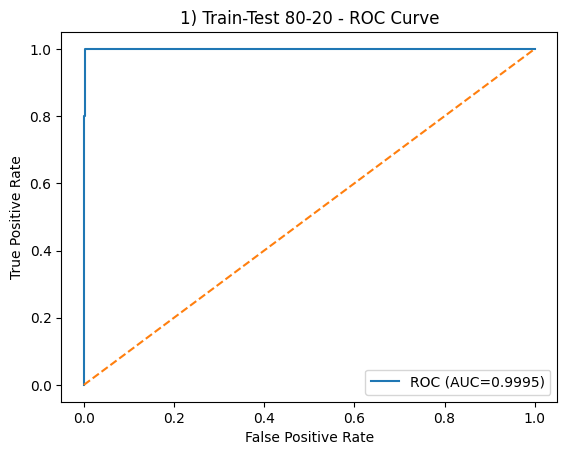


2) Train-Test 70-30
Split: Train=0.7, Val=0.0, Test=0.3
Train distribution before SMOTE: [8164   35]
Train distribution after  SMOTE: [8164 8164]
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - auc: 0.7673 - loss: 0.5995 - precision: 0.7358 - recall: 0.6841
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - auc: 0.9945 - loss: 0.1104 - precision: 0.9914 - recall: 0.9286
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.9992 - loss: 0.0510 - precision: 0.9881 - recall: 0.9859
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - auc: 0.9995 - loss: 0.0362 - precision: 0.9869 - recall: 0.9965
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.9998 - loss: 0.0238 - precision: 0.9931 - recall: 0.9965
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - auc: 0.9998 - loss: 0.0190 - precision: 0.9959 - recall: 0.9975
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - auc: 0.9999 - loss: 0.0140 - precision: 0.9956 - recall: 0.9989
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step

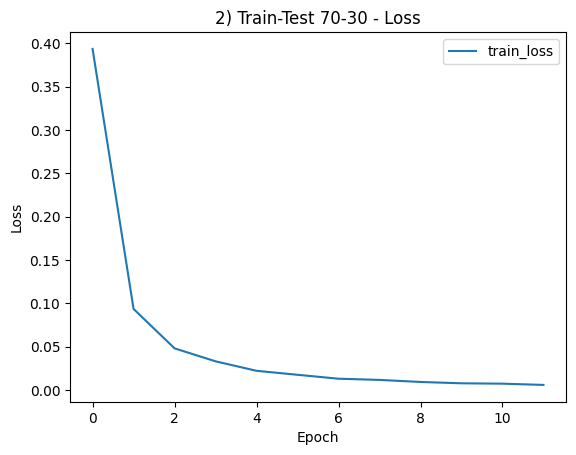

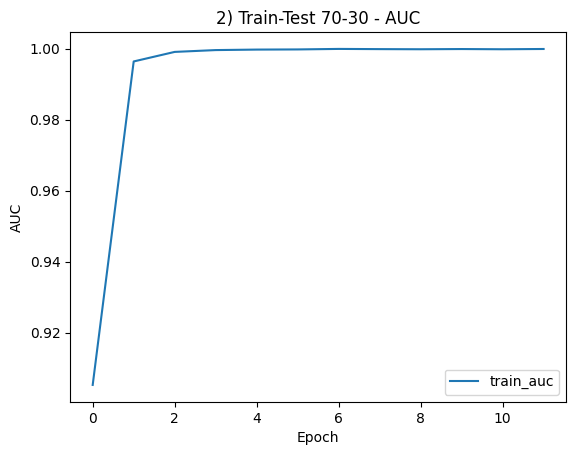

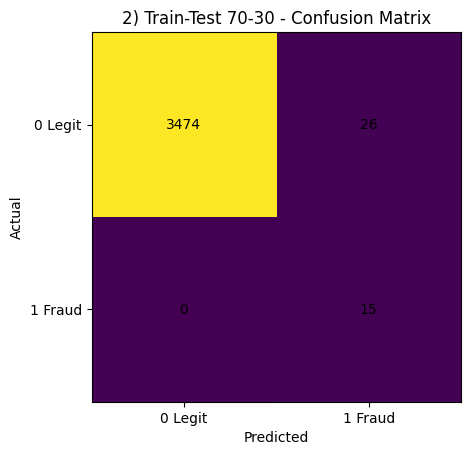

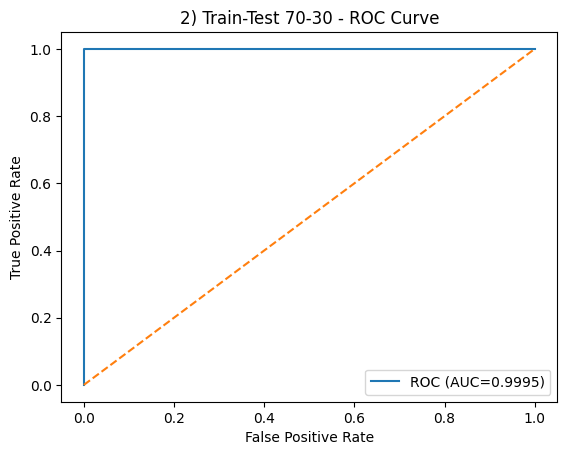


3) Train-Val-Test 60-20-20
Split: Train=0.6, Val=0.2, Test=0.2
Train distribution before SMOTE: [6998   30]
Train distribution after  SMOTE: [6998 6998]
Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - auc: 0.7406 - loss: 0.6366 - precision: 0.7037 - recall: 0.6632 - val_auc: 0.9993 - val_loss: 0.7103 - val_precision: 0.0088 - val_recall: 1.0000
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.9938 - loss: 0.1206 - precision: 0.9918 - recall: 0.9223 - val_auc: 0.9994 - val_loss: 0.5680 - val_precision: 0.0463 - val_recall: 1.0000
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - auc: 0.9986 - loss: 0.0616 - precision: 0.9870 - recall: 0.9806 - val_auc: 0.9993 - val_loss: 0.4393 - val_precision: 0.0758 - val_recall: 1.0000
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - auc: 0.9994 - loss: 0.0421 - precision: 0.9834 - recall: 0.9961 - val_auc: 0.9994 - val_loss: 0.3193 - val_precision: 0.1075 - val_recall: 1.0000
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - auc: 0

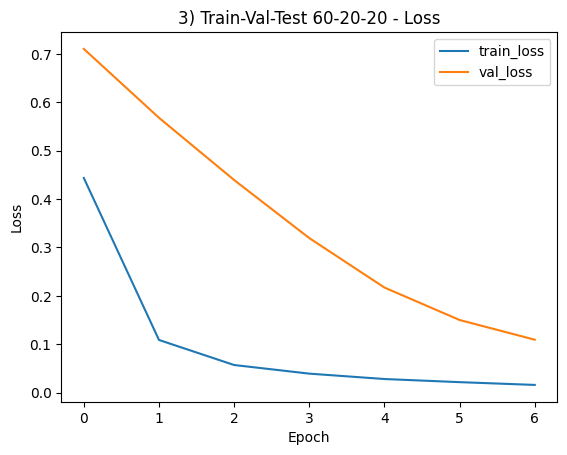

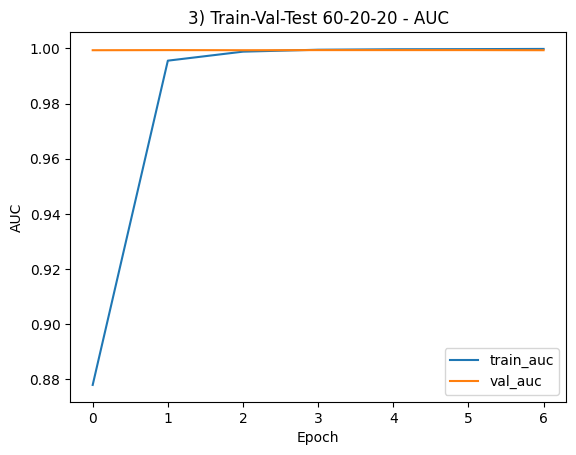

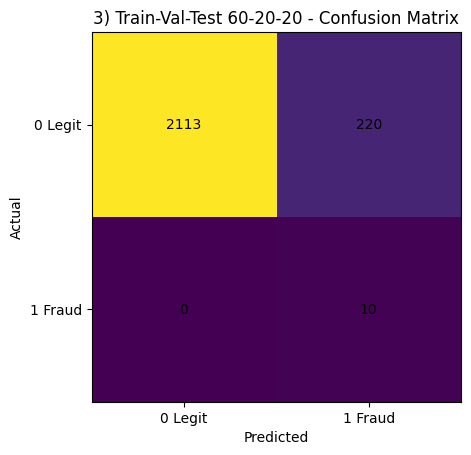

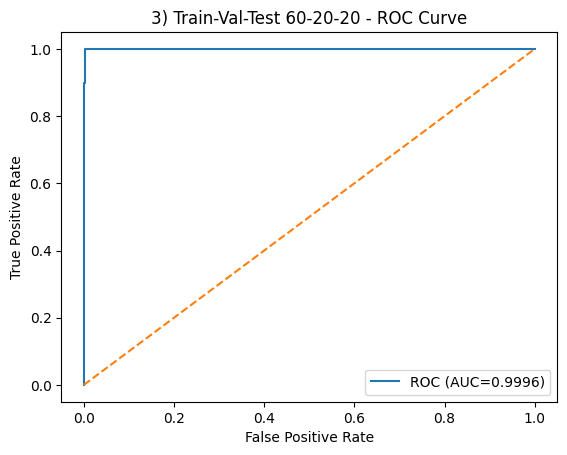


4) Train-Val-Test 70-15-15
Split: Train=0.7, Val=0.15, Test=0.15
Train distribution before SMOTE: [8164   35]
Train distribution after  SMOTE: [8164 8164]
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - auc: 0.7673 - loss: 0.5995 - precision: 0.7358 - recall: 0.6841 - val_auc: 0.9988 - val_loss: 0.7133 - val_precision: 0.0090 - val_recall: 1.0000
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - auc: 0.9945 - loss: 0.1104 - precision: 0.9914 - recall: 0.9286 - val_auc: 0.9988 - val_loss: 0.5552 - val_precision: 0.0374 - val_recall: 1.0000
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - auc: 0.9992 - loss: 0.0510 - precision: 0.9881 - recall: 0.9859 - val_auc: 0.9989 - val_loss: 0.4120 - val_precision: 0.0686 - val_recall: 1.0000
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - auc: 0.9995 - loss: 0.0362 - precision: 0.9869 - recall: 0.9965 - val_auc: 0.9989 - val_loss: 0.2791 - val_precision: 0.1094 - val_recall: 1.0000
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - auc:

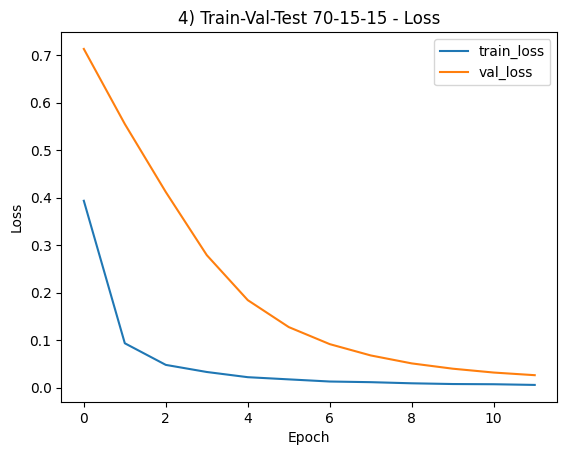

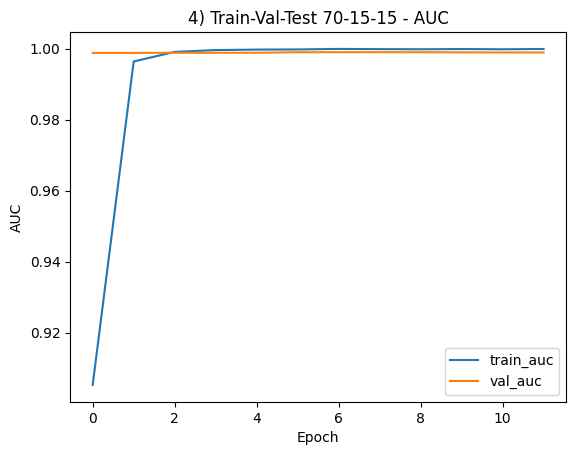

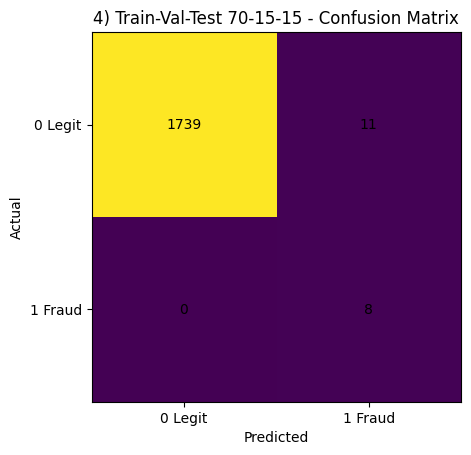

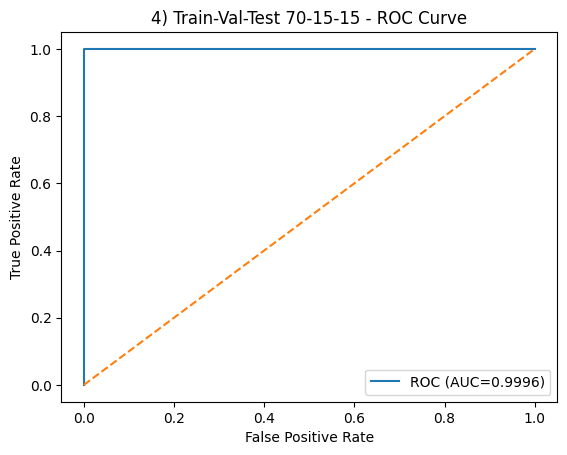

In [14]:
results = []

# 1) 80-20
results.append(run_experiment(
    X, y,
    split_name="1) Train-Test 80-20",
    train_size=0.80, val_size=0.00, test_size=0.20,
    epochs=50
))

# 2) 70-30
results.append(run_experiment(
    X, y,
    split_name="2) Train-Test 70-30",
    train_size=0.70, val_size=0.00, test_size=0.30,
    epochs=50
))

# 3) 60-20-20
results.append(run_experiment(
    X, y,
    split_name="3) Train-Val-Test 60-20-20",
    train_size=0.60, val_size=0.20, test_size=0.20,
    epochs=50
))

# 4) 70-15-15
results.append(run_experiment(
    X, y,
    split_name="4) Train-Val-Test 70-15-15",
    train_size=0.70, val_size=0.15, test_size=0.15,
    epochs=50
))


In [15]:
summary = pd.DataFrame(results)[["split", "precision", "recall", "f1", "roc_auc"]]
summary


,split,precision,recall,f1,roc_auc
0,1) Train-Test 80-20,0.666667,1.0,0.800000,0.999529
1,2) Train-Test 70-30,0.365854,1.0,0.535714,0.999467
2,3) Train-Val-Test 60-20-20,0.043478,1.0,0.083333,0.999571
3,4) Train-Val-Test 70-15-15,0.421053,1.0,0.592593,0.999643
